# GT generator

This notebook does the match between the automatic segmentation and the rim+ slices annotated by the experts.

Result is a mask with an ID for each lesion **(1XXX for rim+ lesions, 2XXX for rim- lesions)**.

In [1]:
import os
import numpy as np
from nibabel import load as load_nii
import nibabel as nib
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure as gbs
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from tqdm import tqdm
sys.path.append("..")
from config import *
from utils import generate_BIDS_path
import pandas as pd

Loading configuration...
Configuration loaded successfully!
_____________________________



In [16]:
dataset_id = DATASET_NIH7T_ID

dataset = AVAILABLE_DATASETS[dataset_id]
results = []
for pat in dataset.get_subjects():
    annotations_paths = dataset.get(return_type="filename", subject=pat, **CONTRASTS["EXPERTS_ANNOTATIONS"])
    segmentation_paths = dataset.get(return_type="filename", subject=pat, **CONTRASTS["SEGMENTATION"])
    
    if len(segmentation_paths) == 0:
        print(f"[{pat}] - Segmentation missing.")
        continue
        
    m_image = nib.load(segmentation_paths[0]) #lesion mask in flair* space
    gt = m_image.get_fdata()
    orientation=m_image.affine

    labeled_mask, num_les = ndimage.label(gt)
    labels = list(np.unique(labeled_mask)[1:])
    a = np.zeros_like(gt).astype('int16')
    rim_dic = {}
    messages = []

    # DEBUGGING
    print(f"> CASE {pat}")

    if len(annotations_paths) == 1:
        # we try to match
        m_image = nib.load(annotations_paths[0]) #rims annotations
        gt_rim = m_image.get_fdata()
        count_r = 0

        gt[gt>0]=1
        #gt_rim[gt_rim>0]=1
        lab_r, rims= ndimage.label(gt_rim, structure = gbs(3,2))
        
        # save the mask with the IDs to easily check after
        nifti_out = nib.Nifti1Image(lab_r, affine=m_image.affine)
        nifti_out.to_filename(annotations_paths[0].replace(".nii.gz", "UIDs.nii.gz"))   #Output Mask
        
        rims_ids = np.unique(lab_r)[1:]
        #rims_ids = np.unique(gt_rim)[1:]

        for rim_id in tqdm(rims_ids):
            #one_lesion = np.zeros_like(labeled_mask)
            coincidences = list(np.unique(((lab_r == rim_id).astype(int) * labeled_mask)))
            if 0 in coincidences:
                coincidences.remove(0)

            if len(coincidences) == 0:
                messages.append(f"[WARNING] Rim {rim_id} is not segmented.")
                results.append((pat, rim_id, "Not segmented", None))
            elif len(coincidences) > 1:
                messages.append(f"[WARNING] Rim {rim_id} intersects with more than one independent lesion segmentations.")
                results.append((pat, rim_id, "> 1 coincidences", None))
            else:
                if coincidences[0] not in rim_dic.keys():
                    rim_dic[coincidences[0]] = []
                rim_dic[coincidences[0]].append(rim_id)
            #mean = np.sum(aux) / np.sum((aux > 0).astype(int))
            #print(aux)
        successful = True
        for message in messages:
            print(message)
            successful = False
        for key in rim_dic.keys():
            if len(rim_dic[key]) > 1:
                print(f"[WARNING] Rims {rim_dic[key]} are confluent.")
                for ins_r_id in rim_dic[key]:
                    results.append((pat, ins_r_id, "Confluent", rim_dic[key]))
                successful = False
            else:
                results.append((pat, rim_id, "Ok"))
    else:
        print(f"[{pat}] - Annotation missing => No rim+ lesions considered.")
        # no rim+ => no matches possible
        successful = True
        rims_ids = []

    if successful:
        count_r = 0
        for key in rim_dic.keys():
            count_r += 1
            a[labeled_mask == key] = 1000 + rim_dic[key][0]
            labels.remove(key)
        # remaining are non rim
        counter = 0
        for key in labels:
            a[labeled_mask == key] = 2000 + counter
            counter += 1

        assert count_r == len(rims_ids)
        #print(np.unique(a))

        output_path = generate_BIDS_path(dataset_id, subject=pat, **CONTRASTS["MASK"])
        nifti_out = nib.Nifti1Image(a, affine=orientation)
        nifti_out.to_filename(output_path)   #Output Mask

        print("SUCCESSFULLY SAVED!")
    else:
        print("NOT SAVED")


> CASE 001


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


SUCCESSFULLY SAVED!
> CASE 002


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


[WARNING] Rims [1, 2, 3] are confluent.
NOT SAVED
> CASE 003


100%|██████████| 22/22 [00:09<00:00,  2.39it/s]


[WARNING] Rim 22 is not segmented.
[WARNING] Rims [5, 12] are confluent.
[WARNING] Rims [8, 14] are confluent.
[WARNING] Rims [17, 21] are confluent.
NOT SAVED
> CASE 004


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


[WARNING] Rims [1, 2, 3] are confluent.
[WARNING] Rims [4, 6] are confluent.
NOT SAVED
> CASE 005


100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


[WARNING] Rims [1, 2] are confluent.
[WARNING] Rims [4, 5, 6, 7, 8] are confluent.
NOT SAVED
> CASE 006


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


[WARNING] Rims [1, 3, 6] are confluent.
[WARNING] Rims [9, 10, 11] are confluent.
NOT SAVED
> CASE 007


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


SUCCESSFULLY SAVED!
> CASE 008


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


[WARNING] Rims [1, 2, 3, 4, 5] are confluent.
NOT SAVED
> CASE 009


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


[WARNING] Rims [1, 2, 3] are confluent.
NOT SAVED
> CASE 010


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


SUCCESSFULLY SAVED!
> CASE 011


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


[WARNING] Rims [1, 2] are confluent.
[WARNING] Rims [3, 4] are confluent.
NOT SAVED
> CASE 012


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


[WARNING] Rims [2, 3] are confluent.
[WARNING] Rims [5, 6, 7, 8] are confluent.
NOT SAVED
> CASE 013


100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


[WARNING] Rims [1, 7, 11, 14] are confluent.
[WARNING] Rims [2, 3, 4, 6, 8, 9, 10, 12, 13] are confluent.
[WARNING] Rims [15, 18] are confluent.
[WARNING] Rims [16, 17, 20, 21, 22, 23, 24, 25] are confluent.
NOT SAVED
> CASE 014


100%|██████████| 41/41 [00:17<00:00,  2.39it/s]


[WARNING] Rims [4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17] are confluent.
[WARNING] Rims [21, 22, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38] are confluent.
NOT SAVED
> CASE 015


100%|██████████| 21/21 [00:08<00:00,  2.43it/s]


[WARNING] Rims [2, 6] are confluent.
[WARNING] Rims [8, 9, 11] are confluent.
[WARNING] Rims [10, 13] are confluent.
[WARNING] Rims [14, 20, 21] are confluent.
[WARNING] Rims [18, 19] are confluent.
NOT SAVED
> CASE 016


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


SUCCESSFULLY SAVED!
> CASE 017


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


[WARNING] Rims [1, 3] are confluent.
[WARNING] Rims [5, 8] are confluent.
[WARNING] Rims [6, 7] are confluent.
NOT SAVED
> CASE 018


100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


[WARNING] Rims [1, 2, 3, 4, 5, 7] are confluent.
[WARNING] Rims [9, 10, 11, 12, 14, 16, 17, 18] are confluent.
NOT SAVED
> CASE 019


100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


SUCCESSFULLY SAVED!
> CASE 020


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

[WARNING] Rims [1, 2, 3, 4] are confluent.
NOT SAVED


# 7T matching results

In [17]:
df = pd.DataFrame(data=results, columns=["patient", "lesion", "status", "comments"])

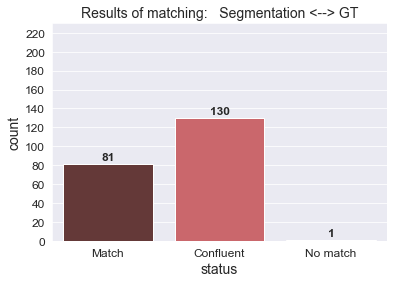

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

CMAPS = {}
CMAPS["redish"] = ("#6B3231", "#DB565D", "#FACCAD", "#FCFAF1")
sns.set_palette(sns.color_palette(CMAPS["redish"]))
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

#df = pd.read_csv("NIH_GT.csv")
df["status"] = df["status"].apply(lambda r: ">1 matches" if r == "> 1 coincidences" else r)
df["status"] = df["status"].apply(lambda r: "No match" if r == "Not segmented" else r)
df["status"] = df["status"].apply(lambda r: "Match" if r == "Ok" else r)
ax = sns.countplot(data=df, x="status")
max_heigh = max([p.get_height() for p in ax.patches])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.03 * max_heigh,
            '{:d}'.format(int(height)),
            ha="center", fontsize=12, fontweight='bold') 
plt.title("Results of matching:   Segmentation <--> GT")
plt.ylim((0,230))
plt.yticks(range(0,230,20))
plt.savefig("NIH_GT.pdf")
pass
#df.to_csv("NIH_GT_3TSEGM.csv")

In [14]:
print(len(df[df["status"] == "Confluent"].index))
print(len(df[df["status"] == "Not segmented"].index))
print(len(df[df["status"] == ">1 coincidences"].index))
print(len(df[df["status"] == "Not segmented"].index))

4
108
